<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/segment_data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/unet.py

Mounted at /content/drive
--2021-09-02 22:55:12--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/unet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2230 (2.2K) [text/plain]
Saving to: ‘unet.py’

unet.py             100%[===================>]   2.18K  --.-KB/s    in 0s      

2021-09-02 22:55:12 (30.1 MB/s) - ‘unet.py’ saved [2230/2230]



In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import preprocess_input

import unet

### Visualize training data

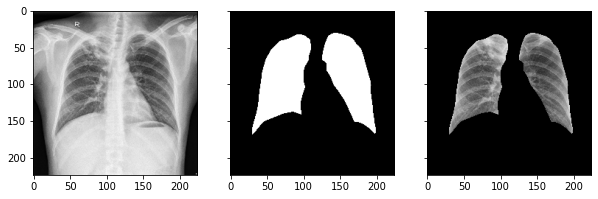

In [3]:
images_path = os.path.join('segment_data', 'images')
masks_path = os.path.join('segment_data', 'masks')

images_list = os.listdir(images_path)
images_list.sort()
masks_list = os.listdir(masks_path)
masks_list.sort() 

index = random.randint(0, len(images_list))
image_path = os.path.join(images_path, images_list[index])
mask_path = os.path.join(masks_path, masks_list[index])
image = load_img(image_path)
image = img_to_array(image)
mask = load_img(mask_path, color_mode='grayscale')
mask = img_to_array(mask)

f, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
axes[0].imshow(image/255.)
axes[1].imshow(np.squeeze(mask)/255., cmap='gray')
axes[2].imshow((image/255.) * (mask/255), cmap='gray')

### Build X and y from image files

Images need to be preprocessed in the same manner as the preprocessing for Densenet. Masks will be 0 or 1, so simply divided by 255. 

In [5]:
n_samples = len(images_list)
X = np.zeros((n_samples, 224, 224, 3))
y = np.zeros((n_samples, 224, 224, 1))
for i, fn in enumerate(images_list):
  image_path = os.path.join(images_path, fn)
  image = load_img(image_path)
  image = img_to_array(image)
  image = preprocess_input(image)
  X[i] = image

  mask_path = os.path.join(masks_path, masks_list[i])
  mask = load_img(mask_path, color_mode='grayscale')
  mask = img_to_array(mask) / 255.
  y[i] = mask

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.1)
X_train.shape, X_test.shape

((633, 224, 224, 3), (71, 224, 224, 3))

### Build the model

In [6]:
input_shape = (224, 224, 3)
model = unet.build_unet(input_shape, 4)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compile and train

In [7]:
model.compile(optimizer='adam', loss=unet.get_dice_loss(), metrics=[unet.dice_coeff])
stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    batch_size=8, 
                    epochs=100,
                    callbacks=[stop],
                    validation_data=(X_test, y_test),
                    validation_steps=1,
                    verbose=1)

Epoch 1/100
80/80 [==============================] - 110s 909ms/step - loss: 0.1702 - dice_coeff: 0.8310 - val_loss: 0.3667 - val_dice_coeff: 0.6333
Epoch 2/100
80/80 [==============================] - 69s 868ms/step - loss: 0.0646 - dice_coeff: 0.9358 - val_loss: 0.1556 - val_dice_coeff: 0.8444
Epoch 3/100
80/80 [==============================] - 69s 867ms/step - loss: 0.0567 - dice_coeff: 0.9436 - val_loss: 0.0943 - val_dice_coeff: 0.9057
Epoch 4/100
80/80 [==============================] - 69s 867ms/step - loss: 0.0478 - dice_coeff: 0.9523 - val_loss: 0.0571 - val_dice_coeff: 0.9429
Epoch 5/100
80/80 [==============================] - 69s 868ms/step - loss: 0.0458 - dice_coeff: 0.9537 - val_loss: 0.0433 - val_dice_coeff: 0.9567
Epoch 6/100
80/80 [==============================] - 69s 867ms/step - loss: 0.0425 - dice_coeff: 0.9560 - val_loss: 0.0419 - val_dice_coeff: 0.9581
Epoch 7/100
80/80 [==============================] - 69s 867ms/step - loss: 0.0463 - dice_coeff: 0.9535 - val_l

### Evaluation

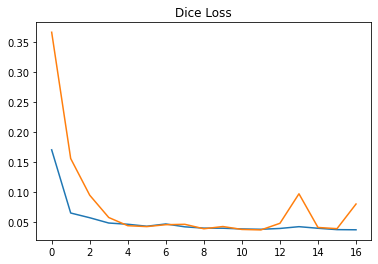

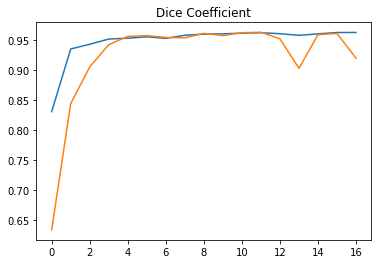

In [8]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Dice Loss')
plt.show()

plt.plot(history.history['dice_coeff'], label='Training')
plt.plot(history.history['val_dice_coeff'], label='Validation')
plt.title('Dice Coefficient')
plt.show()


In [9]:
y_preds = model.predict(X_test, verbose=1)
y_preds = K.cast(y_preds, 'double')
dice = unet.dice_coeff(y_test, y_preds).numpy()
print(f'Dice coefficient for test: {round(dice * 100, 2)}%')

3/3 [==============================] - 16s 2s/step
Dice coefficient for test: 96.16%


### Choose random example and compare masking via model vs. ground truth

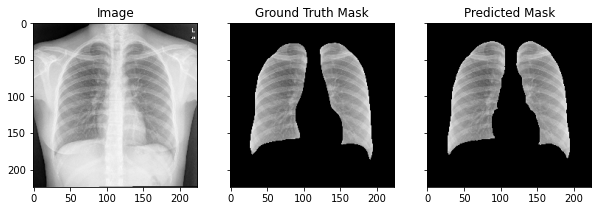

In [10]:
index = random.randint(0, len(images_list))
image_path = os.path.join(images_path, images_list[index])
mask_path = os.path.join(masks_path, masks_list[index])

image = load_img(image_path)
image = img_to_array(image)

x = load_img(image_path)
x = img_to_array(x)
x = np.expand_dims(x, 0)
x = preprocess_input(x)
y = model.predict(x)
pred = (y > 0.5).astype(np.uint8)
mask_pred = pred[0]

mask_gt = load_img(mask_path, color_mode='grayscale')
mask_gt = img_to_array(mask_gt)

f, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
axes[0].imshow(image/255.)
axes[0].set_title('Image')
axes[1].imshow((image/255.) * (mask_gt/255.))
axes[1].set_title('Ground Truth Mask')
axes[2].imshow((image/255.) * (mask_pred), cmap='gray')
axes[2].set_title('Predicted Mask')
plt.show()

### Save model and weights

In [11]:
model_path = os.path.join(BASE_PATH, 'segment_model.h5')
model.save(model_path)
weights_path = os.path.join(BASE_PATH, 'segment_weights.hdf5')
model.save_weights(weights_path)